# 情感分析-分类问题
## 1.数据集处理

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
# 下载数据集（已下载 不需重新下载）
# d2l.DATA_HUB['aclImdb'] = (
#     'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
#     '01ada507287d82875905620988597833ad4e0903')

# data_dir = d2l.download_extract('aclImdb', 'aclImdb')
# print(data_dir)

In [26]:
#@save
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels
data_dir = "data\\aclImdb"
train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review: Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review: Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


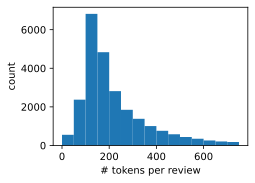

In [4]:
# tokenize化
train_tokens = d2l.tokenize(train_data[0], token='word')
# 建立字典 少于5次的单词不入词表
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 800, 50));

In [5]:
# num_steps = 500  # 序列长度
# train_features = torch.tensor([d2l.truncate_pad(
#     vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
# # 把token映射到字典里id上的500长的向量上
# print(train_features.shape)
# # 打印出第一个向量的前200的长度
# print(train_features[0][:200])

torch.Size([25000, 500])
tensor([31157,  2717,     7,     3,  1398,  1350,    56,  2215,    31,     2,
          169,    83,    15,    46,    80,  9006,    42,   518,   776,   138,
           15,     0,   359,  7182,   190,     8,     2,  5768,  8850,   493,
           84,     6,   263,    10, 31157,     0,  2618,     7,    78,  2641,
            6,   897,    70,     7,     0,    19, 42676,     6,  2701,     0,
            2,  7910,  1890,    35,    64,    67,   257,   148,    55,  1703,
            0,     0,     2,     0,     5,     2,   213,  5388,    37,  2973,
           84,     5,     2,  8534,     9,   635,     4,    55,  9007,   283,
            9,   207,     2,   482,     8,    61,     3,  1831,  4548,   762,
            6,  4381,   215,     2,  3138,     9,  1369, 18939, 42677,    31,
            0, 26680,   133,   441,  7520,     0,   160,   225,     6, 13950,
           32,     5,   117, 34143,     0, 18109,     6, 31157, 26680,     9,
          543,    10,   102,  2041,    

In [6]:
train_iter = d2l.load_array((train_features,
    torch.tensor(train_data[1])), 64)

# X为输入向量，Y为其对应标签
for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
# 每次批量的大小为64个，总共有391组（25000/64）
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


In [7]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
#     data_dir = d2l.download_extract('aclImdb', 'aclImdb')
#     train_data = read_imdb(data_dir, True)
#     test_data = read_imdb(data_dir, False)
    # 已经下载过了 不想重复下载..\data\aclImdb
    data_dir = "data\\aclImdb"
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    # 词元化 tokenize
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    # 建立字典
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    # 生成token字符到字典id的映射向量，向量长度为num_steps 500
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    # 生成小批量大小的输入 批量大小batch_size为64，共有391组 25000/64
    # train_iter内容 X: torch.Size([64, 500]) , y: torch.Size([64])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## 2.网络搭建（双向Lstm）

In [8]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [9]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        # 这里的decoder最后的2 其实就是最后收缩到最上面的时候为2维向量
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # 这里最后输出的是2维 例如[0.1 0.9]所以最后的输出标量应该是0.9的下标1！
        outs = self.decoder(encoding)
        return outs

In [10]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

# 初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [11]:
# 这里使用Glove进行嵌入预训练向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [13]:
# 把预训练向量用到net网络上
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.257, train acc 0.894, test acc 0.853
232.8 examples/sec on [device(type='cuda', index=0)]


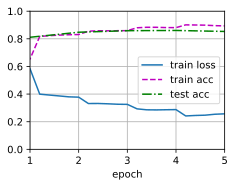

In [14]:
lr, num_epochs = 0.01, 5
# 优化算法
trainer = torch.optim.Adam(net.parameters(), lr=lr)
# 损失函数选择 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction="none")
# 开始训练
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [18]:
# 开始预测
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    # 这里就是返回这个维度的最大值的index 比如[0.4 0.6]这个时候就是返回0.6的下标就是1
    # 所以y就是用在损失下降的时候，预测的标号和真正的标号来做损失
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [19]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [20]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [21]:
predict_sentiment(net, vocab, 'i like qinFei,she is so pretty')

'positive'